In [59]:
import pandas as pd
from data_clean import DataClean
from add_public_data import PublicData
from create_lag import CreateLag
from cust_seg import CustSeg
from split import Split
from std_scale import StdScale
from pred_model import PredModel
from forcast import Forcast
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import rc
from model_functions import plot_rmse, model_clusters

In [33]:
%matplotlib inline
pd.set_option('max_columns',500)
font = {'size': 20}
rc('font', **font)
plt.style.use('seaborn-bright')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
df = pd.read_pickle('../data/SRP/raw_subset_20k.pkl')

In [10]:
# middle 1
dc = DataClean(remove_nan_rows=True)
df_clean = dc.fit_transform(df)

In [12]:
df_clean.head()

,visit_date,prev_visit_date,prev_item_move_date,ship_id,address1,sales_rep_id,item_id,old_item_id,item_UPC,old_item_UPC,item_description,qty_POG_limit,qty_n,qty_f,qty_o,qty_d,qty_delivery,qty_sales,unit_price,qty_prev_end_inventory,qty_out,qty_start_inventory,qty_end_inventory,qty_inv_out,qty_ex_del,qty_shrink,qty_shrink_out,qty_shrink_ex_del,sales_value,shrink_value,shrink_to_sales_value_pct,shrink_value_out,shrink_to_sales_value_pct_out,shrink_value_ex_del,shrink_to_sales_value_pct_ex_del,ship_list_pk,sales_rep_id_2,address2,city,state,list_header_id,last_edit_date,creation_date,visit_date_int,prev_visit_date_int,prev_item_move_date_int,last_edit_date_int,creation_date_int,zip_code,qty_shrink_per_day,shrink_value_per_day,item_category_8,item_category_10,item_category_16,item_category_19,item_category_31,item_category_38,item_category_41,item_category_43,item_category_44,item_category_46,item_category_58,item_category_62,item_category_77,item_category_79,item_category_90,customer_id_2139,customer_id_1635139,customer_id_1903139,customer_id_2331150,customer_id_2741156,customer_id_2773156,customer_id_2782156,customer_id_2956160,customer_id_2977160,customer_id_3083182,customer_id_3088198,customer_id_3088201,customer_id_3089336,customer_id_3093327,customer_id_3093329,item_category,customer_id
2061709,2017-09-27,2017-09-13,2017-09-06,118558,SPEEDWAY #2325,100223113,2975455,5743,5254860398,60870758926,IGEAR COATED WORK GLOVE,4,2,0,0,0,0,2,4.99,4.0,2,2,4,2.0,2.0,0.0,0,0.0,9.98,0.00,0.0,7.98,79.959920,0.00,0.0,138671,100223113,635 TECUMSEH,DUNDEE,MI,3386280,2017-09-09 09:00:38,2016-08-23 07:37:37,1.506492e+09,1.505282e+09,1.504678e+09,1.504969e+09,1.471959e+09,48131,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,58,2331150
2084815,2017-09-28,2017-09-14,2017-09-14,123692,SPEEDWAY #7105,100264113,6834,6834,35828694004,35828694004,PILL-STACKER 2 EPHEDRA FREE,6,6,0,0,0,0,2,0.87,6.0,6,0,6,6.0,6.0,4.0,4,4.0,1.74,3.48,200.0,3.22,185.057471,3.48,200.0,139284,100264113,5540 MURFREESBORO RD,LA VERGNE,TN,3386280,2016-08-23 07:37:38,2016-08-23 07:37:37,1.506578e+09,1.505369e+09,1.505369e+09,1.471959e+09,1.471959e+09,37086,0.285714,0.248571,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,44,2331150
3448678,2018-01-09,2017-12-19,2017-12-19,99160,SHEETZ - DSD #234,100212113,2987433,2987433,8079841558,8079841558,SR KARAOKE MIC,4,0,4,0,0,0,0,17.99,0.0,4,0,0,0.0,0.0,0.0,4,0.0,0.00,0.00,0.0,71.96,7196.000000,0.00,0.0,132637,100212113,239 THREE SPRINGS DR,WEIRTON,WV,2634209,2016-08-23 07:37:38,2016-08-23 07:37:37,1.515481e+09,1.513667e+09,1.513667e+09,1.471959e+09,1.471959e+09,26062,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,16,1903139
2413859,2017-10-19,2017-10-05,2017-10-05,133058,SPEEDWAY #6434,100008110,1023108,1023108,71941070001,71941070001,5 HR-XSTRENGTH BERRY (718128),60,4,0,0,0,0,4,1.74,60.0,4,56,60,4.0,4.0,0.0,0,0.0,6.96,0.00,0.0,2.96,42.528736,0.00,0.0,142567,100008110,3270 VINELAND ROAD,KISSIMMEE,FL,3386280,2017-03-25 04:09:03,2016-08-23 07:37:37,1.508393e+09,1.507183e+09,1.507183e+09,1.490436e+09,1.471959e+09,34746,0.000000,0.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,44,2331150
2022997,2017-09-25,2017-09-11,2017-09-11,119436,SPEEDWAY #5241,100287114,2100131,2100131,60870716188,60870716188,ELEC-4' MICRO CHARGE/SYNC CABLE,11,1,0,0,0,0,0,6.53,11.0,1,10,11,1.0,1.0,1.0,1,1.0,0.00,6.53,653.0,6.53,653.000000,6.53,653.0,138130,100287114,711 S MAIN ST,ENGLEWOOD,OH,3386280,2017-01-05 10:00:36,2016-08-23 07:37:37,1.506319e+09,1.505110e+09,1.505110e+09,1.483636e+09,1.471959e+09,45322,0.071429,0.466429,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,16,2331150


In [13]:
# middle 2
pub = PublicData(include_crime=False, remove_nan_rows=True)
df_public_cust = pub.fit_transform(df_clean)

In [14]:
# left 1
cl_cat = CreateLag(lag_periods=2, col_filters=['address1', 'item_category'], 
                   date_col='visit_date', lag_vars=['qty_shrink_per_day', 'shrink_value_per_day'], 
                   col_name_suf='_by_cat', remove_nan_rows=True)
df_lag_cat = cl_cat.fit_transform(df_clean)

['qty_shrink_per_day', 'shrink_value_per_day', 'POP2010', 'FD_ratio', 'unemp_rate', 'dens_sq_mile']


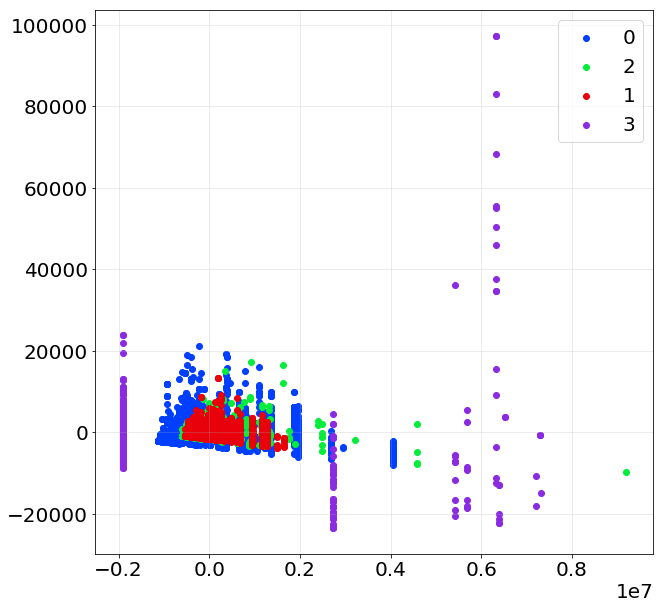

In [39]:
# middle 3
cs = CustSeg(clusters=4, plot=True)
cust_table = cs.fit_transform(df_public_cust)
cust_table.groupby('cluster').mean()

In [58]:
cust_table.groupby('cluster').mean()

,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,avg_UPC_per_visit,days_between_visits
cluster,,,,,,,,
0,0.010325,0.063637,1.131814e+06,0.145723,0.086061,3697.445035,1.093312,23.350826
1,0.022819,0.129050,5.434503e+05,0.316896,0.075032,1748.903772,1.103161,26.170827
2,0.290814,1.305489,6.117699e+05,0.225269,0.090070,2046.336318,1.104436,31.152484
3,0.017994,0.097483,7.922596e+06,0.061272,0.081564,17718.752667,1.084896,11.061832


In [40]:
# right 1
cl_store = CreateLag(lag_periods=2, col_filters=['address1'], 
                   date_col='visit_date', lag_vars=['qty_shrink_per_day', 'shrink_value_per_day'], 
                   col_name_suf='_by_store', remove_nan_rows=True)
df_lag_store = cl_store.fit_transform(df_clean)

### Public for Lag

In [41]:
# left 2
df_public_cat = pub.fit_transform(df_lag_cat)

In [42]:
# right 2
df_public_store = pub.fit_transform(df_lag_store)

### Split

In [43]:
non_feature_cols = ['shrink_value', 'shrink_to_sales_value_pct', 'shrink_value_out', 'shrink_to_sales_value_pct_out',
               'shrink_value_ex_del', 'shrink_to_sales_value_pct_ex_del', 'qty_inv_out', 'qty_shrink',
               'qty_shrink_ex_del', 'qty_shrink_out', 'qty_end_inventory', 'qty_f', 'qty_out', 'qty_ex_del',
               'qty_n', 'qty_delivery', 'qty_o', 'qty_d', 'qty_shrink_per_day', 'shrink_value_per_day']

In [44]:
# left 3
spl_cat = Split(non_feature_cols, target_col='shrink_value_per_day', split_by_time=False)
spl_cat.fit(df_public_cat, cust_table)
X, y, X_train_cat, X_test_cat, y_train_cat, y_test_cat \
= spl_cat.transform(df_public_cat, cust_table)

In [45]:
# right 3
split_date = pd.to_datetime('12/15/2017')
spl_store = Split(non_feature_cols, target_col='shrink_value_per_day', split_by_time=True, date_col='visit_date', split_date=split_date)
spl_store.fit(df_public_store, cust_table)
X, y, X_train_store, X_test_store, y_train_store, y_test_store \
= spl_store.transform(df_public_store, cust_table)

### Std and Scale

In [46]:
ss = StdScale(std=True, scale=True)

In [47]:
# left 4
X_train_cat_ss = ss.fit_transform(X_train_cat)
X_test_cat_ss = ss.fit_transform(X_test_cat)

In [48]:
# right 4
X_ss = ss.fit_transform(X)
X_train_store_ss = ss.fit_transform(X_train_store)
X_test_store_ss = ss.fit_transform(X_test_store)

### Test Models

In [ ]:
# left 
cluster_rmse, naive_rmse, cluster_models = model_clusters(mlp_list, X_train, X_test, X_test_ns, 'shrink_value_per_day_lag1_by_cat', model_mask_cols, y_train, y_test)
plot_rmse(cluster_rmse, naive_rmse, num_clusters=len(X_train.cluster.unique()), 
          title='Predicting Next Visit Shrink Value')

### Model

In [49]:
model = MLPRegressor()
params = {'hidden_layer_sizes': [(300,), (100,), (50,50), (50,50,50)], 'learning_rate_init': [0.01, 0.001, 0.0001], 
          'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['adam'],  'max_iter': [200]}
params_basic = {'hidden_layer_sizes': [(10)], 'learning_rate_init': [0.01], 
          'activation': ['relu'], 'solver': ['adam'],  'max_iter': [10]}

In [50]:
# left 5
pm = PredModel(model, params_basic)
pm.fit(X_train_cat_ss, y_train_cat)


cluster:  1

cluster:  2

cluster:  3

cluster:  4


In [52]:
# left 5 (continued)
preds = pm.predict(X_test_cat_ss)
preds[:10]

[0.4347946323926315,
 -0.15047502849132935,
 -0.40071836693012924,
 0.34731468983189745,
 -0.49726221850990854,
 0.28328703334103583,
 0.3697896535512033,
 -0.30552759204381674,
 -0.011366087424604933,
 1.3767777002418975]

In [56]:
# right 5
forc_cols = ['FD_ratio', 'LAPOP1_10', 'POP2010', 'dens_sq_mile', 'unemp_rate', 'qty_POG_limit', 'unit_price', 
             'shrink_value_per_day_lag1_by_store', 'shrink_value_per_day_lag2_by_store' ]
for col in X_ss.columns:
    if 'customer_id' in col:
        forc_cols.append(col)
fc = Forcast(model, params_basic, forc_cols, num_periods=4)
fc.fit(X_ss, y)


cluster:  1

cluster:  2

cluster:  3

cluster:  4


In [57]:
# right 5 (continued)
forc_cust_table = fc.forcast(cust_table)
forc_cust_table.head()

,qty_shrink_per_day,shrink_value_per_day,POP2010,FD_ratio,unemp_rate,dens_sq_mile,city,state,zip_code,customer_id,avg_UPC_per_visit,days_between_visits,last_visit,cluster,period1_forc_shrink_value_per_day_per_item,period1_pred_date,period2_forc_shrink_value_per_day_per_item,period2_pred_date,period3_forc_shrink_value_per_day_per_item,period3_pred_date,period4_forc_shrink_value_per_day_per_item,period4_pred_date
address1,,,,,,,,,,,,,,,,,,,,,,
#501 PACWEST/JACKSON,-0.043478,-0.398696,425363.0,0.228642,0.08,2995.890411,VANCOUVER,WA,98665,3088198,1.0,0.000000,2017-07-13,0,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
#505 PACWEST/JACKSON,0.200000,2.158000,735334.0,0.096296,0.06,6111.880661,PORTLAND,OR,97232,3088198,1.0,0.000000,2017-11-22,2,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
#506 PACWEST/JACKSON,0.198864,2.326761,735334.0,0.096296,0.06,6111.880661,PORTLAND,OR,97232,3088198,1.0,26.000000,2017-12-14,2,239290.865088,2018-01-09 00:00:00.000000,144573.994145,2018-02-04 00:00:00.000000,210246.623951,2018-03-02,173096.980194,2018-03-28 00:00:00.000000
#508 PACWEST/JACKSON,0.312302,1.569603,735334.0,0.096296,0.09,3965.349290,PORTLAND,OR,97220,3088198,1.0,44.333333,2017-12-14,2,239289.740177,2018-01-27 07:59:59.971200,144573.887563,2018-03-12 16:00:00.028800,210245.895782,2018-04-26,173096.617993,2018-06-09 07:59:59.971200
#509 PACWEST/JACKSON,0.000000,0.000000,735334.0,0.096296,0.08,2925.449871,FAIRVIEW,OR,97024,3088198,1.0,0.000000,2017-09-28,0,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
